# Configure Source Model using class: Reflection_Source

XSPEC provides the `xspec.models.Reflection_Source` and `xspec.models.Transmission_Source` classes in order to provide an interpolation function over multiple source spectra simulations. 

The reflection source spectrum as a function of source voltage and anode angles can be written as:

$$
S^{sr}(E, v, \psi) = S^{sr}(E, v, \psi_0) \frac{Ph(E, v, \psi)}{Ph\left(E, v, \psi_0\right)}.
$$

where:

- $S^{sr}(E, v, \psi_0)$ is the interpolation function over a given list of spectra with different source voltages. It represents the source spectrum as a function of energy ($E$), source voltage ($v$), and a fixed anode angle ($\psi_0$), which serves as a reference.

- $Ph(E, v, \psi)$ is the Philibert absorption correction factor, applied in an analytical model that considers the anode angle. This factor corrects for the absorption effects that are dependent on the anode angle ($\psi$).

Here is an example to configure the provided reflection source class. With the source spectra provided, configure the X-ray source by defining two continuous variables, voltages, and takeoff angle. The process involves two principal steps:

1. Configure the source model with `Reflection_Source` by passing two continuous parameters, voltages, and takeoff angle, which should be a tuple (init value, min, max). Note that setting min and max to `None` indicates that we do not need to optimize this parameter.

2. Reflection sources are an interpolation-based model. Use `set_src_spec_list` to set up a list of simulation source spectra with corresponding source voltages.

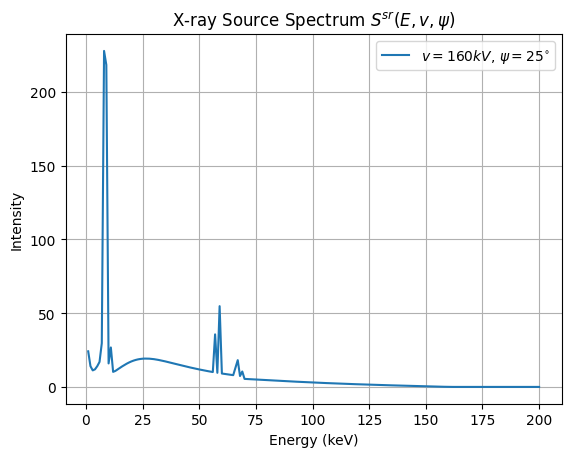

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import spekpy as sp
import torch
from xspec.models import Reflection_Source

# Generate source spectra using Spekpy for a range of source voltages and a fixed takeoff angle.
min_simkV = 30
max_simkV = 200
dsize = 0.01  # mm, detector size
simkV_list = np.linspace(min_simkV, max_simkV, 18, endpoint=True).astype('int')
reference_anode_angle = 11  # degrees
energies = np.linspace(1, max_simkV, max_simkV)  # energy range

src_spec_list = []
for simkV in simkV_list:
    s = sp.Spek(kvp=simkV + 1, th=reference_anode_angle, dk=1, mas=1, char=True)  # Spekpy model
    k, phi_k = s.get_spectrum(edges=True)  # Get energy and fluence spectrum
    phi_k = phi_k * ((dsize / 10) ** 2)  # Adjusting fluence for detector size, default detector size is 1*1 cm^2

    # Creating a source spectrum array for each voltage
    src_spec = np.zeros((max_simkV))
    src_spec[:simkV] = phi_k[::2]  # Fill in the spectrum values
    src_spec_list.append(src_spec)

# Initialize the Reflection_Source model with specified voltage and takeoff angle ranges.
source = Reflection_Source(voltage=(160, 30, 200), takeoff_angle=(25, 5, 45), single_takeoff_angle=True)
source.set_src_spec_list(src_spec_list, simkV_list, reference_anode_angle)  # Set the source spectral list

# Plot the resulting spectrum without gradient descent modifications (torch.no_grad() context)
with torch.no_grad():
    plt.plot(energies, source(energies), label='$v=160 kV$, $\psi=25^{\circ}$')

plt.xlabel('Energy (keV)')  # X-axis label
plt.ylabel('Intensity')  # Y-axis label
plt.title('X-ray Source Spectrum $S^{sr}(E, v, \psi)$')  # Plot title
plt.legend()  # Add legend
plt.grid(True)  # Add grid for better readability
plt.show()  # Display the plot


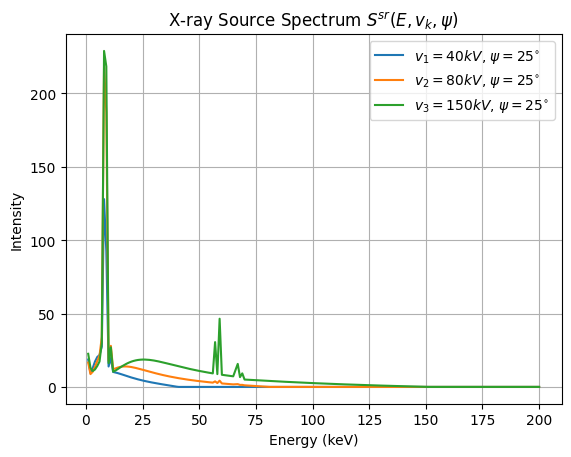

In [2]:
# Initialize the Reflection_Source model with specified voltage and takeoff angle ranges.
voltage_list = [40, 80, 150]
sources = [Reflection_Source(voltage=(v, 30, 200), takeoff_angle=(25, 5, 45), single_takeoff_angle=True) for v in voltage_list]
for si, source in enumerate(sources):
	source.set_src_spec_list(src_spec_list, simkV_list, reference_anode_angle)  # Set the source spectral list
	with torch.no_grad():
		plt.plot(energies, source(energies), label='$v_%d=%d kV$, $\psi=25^{\circ}$'%(si+1, voltage_list[si]))

plt.xlabel('Energy (keV)')  # X-axis label
plt.ylabel('Intensity')  # Y-axis label
plt.title('X-ray Source Spectrum $S^{sr}(E, v_k, \psi)$')  # Plot title
plt.legend()  # Add legend
plt.grid(True)  # Add grid for better readability
plt.show()  # Display the plot

# Configure Filter Model using class: Filter

In X-ray systems, filters are always used to protect the detector and enhance image quality by selectively absorbing low-energy X-rays that contribute to image noise without improving image contrast. According to Beer's law, the response of a single filter is

$$
s^{fl}\left(E; M^{fl}, T^{fl}\right) = \mathrm{e}^{-\mu(E, M^{fl}) T^{fl}}
$$

where:

- $M^{fl}$ denotes the filter material, which is a discrete parameter with only a limited set of choices. Let's assume $M^{fl} \in \{Al, Cu\}$, indicating that the filter material can either be Aluminum (Al) or Copper (Cu).
- $\mu(E, M^{fl})$ is the Linear Attenuation Coefficient (LAC) of material $M^{fl}$ at energy $E$.
- $T^{fl}$ denotes filter thickness, which is a continuous parameter within a continuous range.

We provide the `xspec.models.Filter` class in order to provide an analytical filter model for gradient descent. Here is an example to configure a single filter $s^{fl}\left(E; M^{fl}, T^{fl}\right)$.

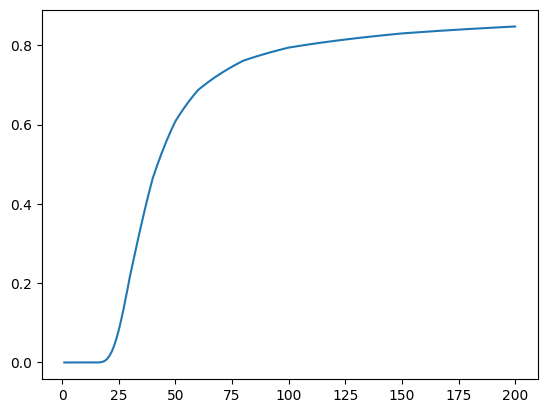

In [3]:
from xspec import Material
from xspec.models import Filter

# Example configurations for a filter
psb_fltr_mat = [Material(formula='Al', density=2.702), Material(formula='Cu', density=8.92)]
filter = Filter(psb_fltr_mat, thickness=(5, 0, 10))

# Plot the source spectrum with given initial value.
with torch.no_grad():
	plt.plot(energies, filter(energies))

The filter response of an X-ray scan, composed of multiple filters. The overall filter response is defined as the product of the responses from multiple different filters. Mathematically, the filter response is represented as:

$$
S^{fl}(E) = \prod_{p=1}^{N^{fl}} s^{fl}\left(E; M_p^{fl}, T_p^{fl}\right),
$$

where,

- $M_p^{fl}$ denotes the $p^{th}$ filter material.
- $\mu(E, M_p^{fl})$ is the Linear Attenuation Coefficient (LAC) of the $p^{th}$ filter made of material $M_p^{fl}$ at energy $E$,
- and $T_p^{fl}$ denotes its thickness.

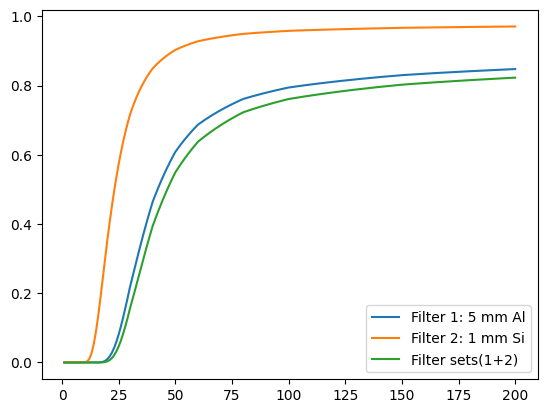

In [4]:
from xspec import Material
from xspec.models import Filter

# Example configurations for a filter
# Material takes chemical composition formula and density g/cm^3
psb_fltr_mat = [Material(formula='Al', density=2.702), Material(formula='Cu', density=8.92)]
# Filter 1 thickness is initialized with 5 mm and should be estiamted within [0, 10] mm
filter_1 = Filter(psb_fltr_mat, thickness=(5, 0, 10))

# Filter 2's material can be only silicon.
# Filter 2 thickness is initialized with 1 mm and should be estiamted within [0, 2] mm
filter_2 = Filter([Material(formula='Si', density=2.33)], thickness=(1, 0, 2))

# Plot the filter response with the first possible material and initial thickness.
with torch.no_grad():
    plt.plot(energies, filter_1(energies), label = 'Filter 1: 5 mm Al')
    plt.plot(energies, filter_2(energies), label = 'Filter 2: 1 mm Si')
    plt.plot(energies, filter_1(energies)*filter_2(energies), label = 'Filter sets(1+2)')	

plt.legend()

# Configure Scintillatro Model using class: Scintillator

A scintillator converts absorbed X-ray photon energies into visible light photons. The response of various scintillators, often modeled using MCNP simulations, can be represented as:

$$
S^{sc}\left(E ; M^{sc}, T^{sc}\right) = \frac{\mu^{en}(E;  M^{sc})}{\mu(E;  M^{sc})}\left(1 - e^{-\mu(E;  M^{sc}) T^{sc}}\right) E,
$$

where

- $M^{sc}$ denotes the scintillator material, which is a discrete parameter with only a limited set of choices. Let's assume $M^{sc} \in \{CsI, Lu_3Al_5O_{12}, CdWO_4\}$.
- $\mu^{en}(E;  M^{sc})$ is the linear energy-absorption coefficient of the scintillator made of $M^{sc}$ and
- $\mu(E;  M^{sc})$ represents the Linear Attenuation Coefficient (LAC) of the scintillator made of $M^{sc}$.
- $T^{sc}$ denotes scintillator thickness, which is a continuous parameter within a continuous range.

We provide the `xspec.models.Scintillator` class in order to provide an analytical scintillator model for gradient descent. Here is an example to configure a scintillator $S^{sc}\left(E ; M^{sc}, T^{sc}\right)$ with only one possible material CsI.

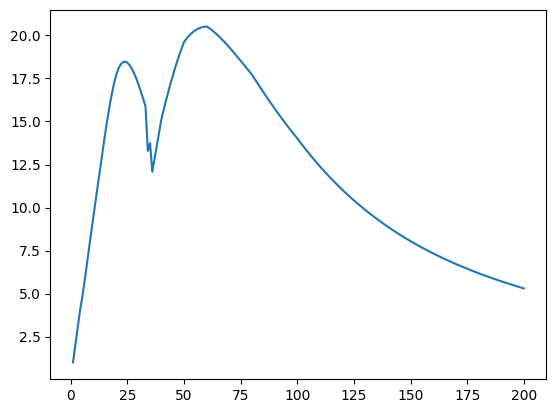

In [5]:
from xspec import Material
from xspec.models import Scintillator

# Example configurations for scintillators

scint_params_list = [
	{'formula': 'CsI', 'density': 4.51},
	# Add additional materials as required
]
psb_scint_mat = [Material(formula=scint_p['formula'], density=scint_p['density']) for scint_p in scint_params_list]
scintillator = Scintillator(materials=psb_scint_mat, thickness=(0.25, 0.01, 0.5))

# Plot the filter response with the first possible material and initial thickness.
with torch.no_grad():
	plt.plot(energies, scintillator(energies))